In [1]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from importlib import reload

# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/beta-dirichlet-factor')
import factor_model
reload(factor_model)

<module 'factor_model' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-dirichlet-factor/factor_model.py'>

In [2]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/'
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

### Settings and Load data

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [4]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'

cell_types = ['Brain_Non-Myeloid_brain_pericyte','Brain_Non-Myeloid_oligodendrocyte_precursor_cell','Brain_Non-Myeloid_endothelial_cell','Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']

#ignoring Bergmann_glial_cell since very few cells

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/


Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
7816
16190
The maximum junction count was initially:  150346
80
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
2  A14-

In [5]:
cell_index_tensor, junc_index_tensor, my_data = make_torch_data(final_data, **float_type)

The number of cells going into training data is:
7816
7816


/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py:333: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  ycount_lookup = torch.sparse_coo_tensor(


In [6]:
simple_data = final_data[["cell_id_index", "Cluster", "cell_type", "junction_id_index", "juncratio", "junc_count", "cluster_count",  "junction_id", "gene_id"]]
#sns.kdeplot(data=final_data, x="juncratio", hue="cell_type", cumulative=True, common_norm=False, common_grid=True)

### Start with a simple PCA using imputed values 

In [7]:
# make matrix of junctions by cells and fill with juncratio values 
mat = np.zeros((len(final_data.cell_id_index.unique()), len(final_data.junction_id_index.unique())))
mat[final_data.cell_id_index, final_data.junction_id_index] = final_data.juncratio
mat[~(final_data.cell_id_index), ~(final_data.junction_id_index)] = np.nan

# imput nan values using mean of each row (does this make sense?)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(mat)
mat_imputed = imp.transform(mat)

# run PCA on mat_imputed 
pca = PCA(n_components=10)
pca.fit(mat_imputed)
print(pca.explained_variance_ratio_)

[0.0672032  0.01925902 0.01560112 0.01093991 0.00515439 0.00346535
 0.00298154 0.00264372 0.00224775 0.00208009]


In [8]:
pcs = pca.transform(mat_imputed)
pcs_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
cell_types_pcs = cell_ids_conversion["cell_type"]

Text(0.5, 1.0, 'PCA of Junction Usage Ratios (imputed matrix)')

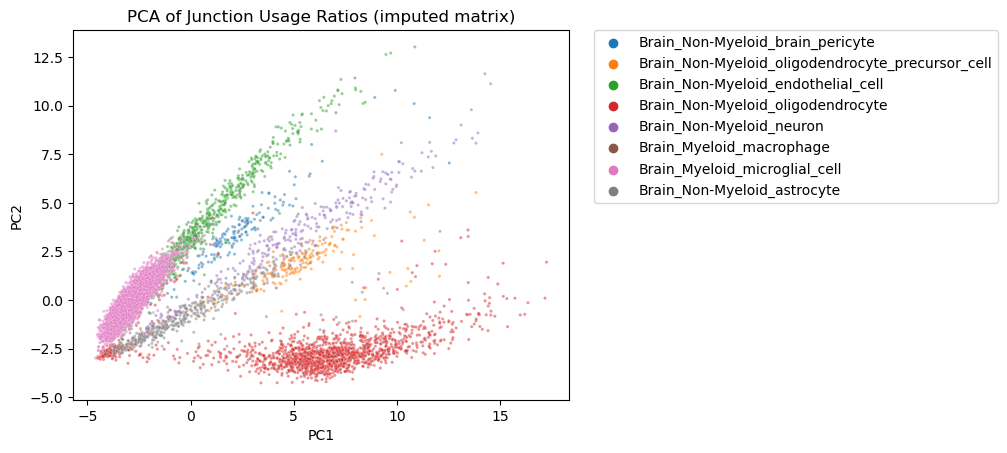

In [9]:
# plot first two PCs
sns.scatterplot(data=pcs_df, x="PC1", y="PC2", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

Text(0.5, 1.0, 'PCA of Junction Usage Ratios (imputed matrix)')

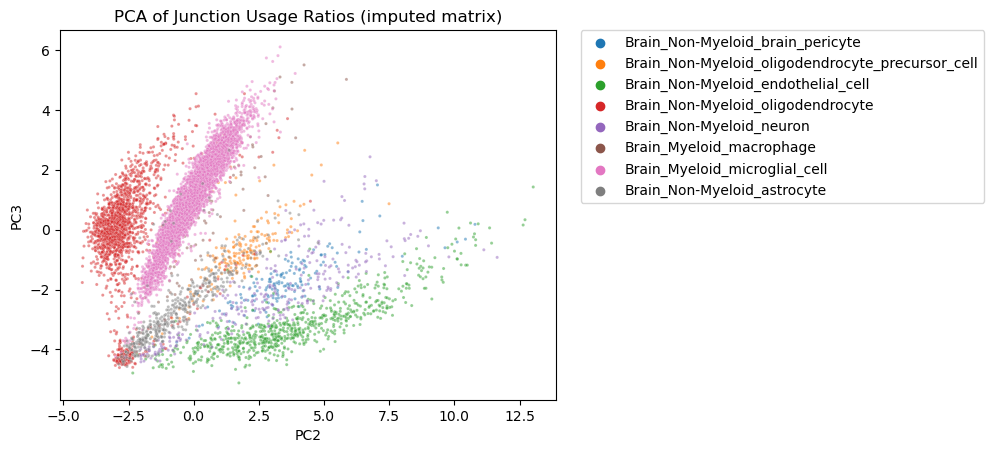

In [10]:
# plot first and third PCs
sns.scatterplot(data=pcs_df, x="PC2", y="PC3", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

### Take a quick look at coverage of reads across junctions

Text(0.5, 1.0, 'Junction Coverage per Cell (read counts/1000)')

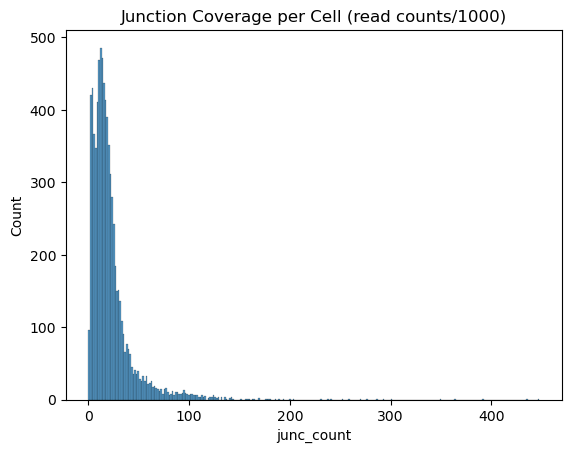

In [11]:
cell_junc_cov = final_data.groupby("cell_id_index").junc_count.sum()
cell_cluster_cov = final_data.groupby("cell_id_index").cluster_count.sum()

# plot histogram of coverage
sns.histplot(cell_junc_cov/1000)
plt.title("Junction Coverage per Cell (read counts/1000)")

Text(0.5, 1.0, 'Cluster Coverage per Cell (read counts/1000)')

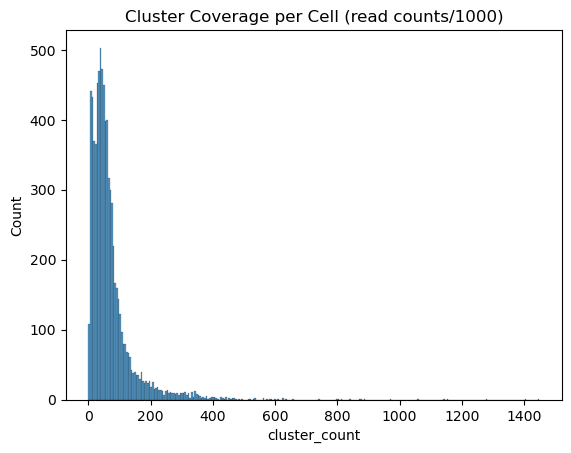

In [12]:
# plot histogram of coverage clusters 
sns.histplot(cell_cluster_cov/1000)
plt.title("Cluster Coverage per Cell (read counts/1000)")

### Get ready for model training 

In [13]:
if device == torch.device('cuda'):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [14]:
indices = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values = torch.tensor(final_data['junc_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells = final_data['cell_id_index'].max() + 1
num_junctions = final_data['junction_id_index'].max() + 1
size = (num_cells, num_junctions)
# Create a sparse tensor
y_tensor = torch.sparse_coo_tensor(indices, values, size)

In [15]:
indices_counts = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values_counts = torch.tensor(final_data['cluster_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells_counts = final_data['cell_id_index'].max() + 1
num_junctions_counts = final_data['junction_id_index'].max() + 1
size_counts = (num_cells_counts, num_junctions_counts)
# Create a sparse tensor
total_counts_tensor = torch.sparse_coo_tensor(indices_counts, values_counts, size_counts)

### Run factor model!

In [36]:
# import reload 
reload(factor_model)

<module 'factor_model' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-dirichlet-factor/factor_model.py'>

Not using global prior for psi, junctions are independent across factors
Initialization 1 with seed 1679
Define the guide
Fit the model


Epoch 0, Loss: 254280000.7308945
Epoch 10, Loss: 144955286.0296945
Epoch 20, Loss: 98131432.87210786
Epoch 30, Loss: 78581394.73502135
Epoch 40, Loss: 70091290.67022109
Epoch 50, Loss: 66118967.060254574
Epoch 60, Loss: 63981639.45134354
Epoch 70, Loss: 62647307.093868256
Epoch 80, Loss: 61738599.727160096
Epoch 90, Loss: 61055577.80689347


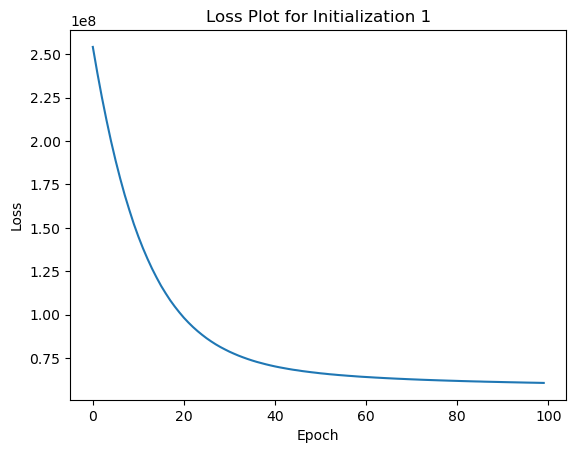

Sample from the guide (posterior)
Extract the latent variables
Initialization 2 with seed 3090
Define the guide
Fit the model
Epoch 0, Loss: 258020666.52616292
Epoch 10, Loss: 147771344.23038375
Epoch 20, Loss: 99625576.52311897
Epoch 30, Loss: 78996402.42080045
Epoch 40, Loss: 69971806.97010255
Epoch 50, Loss: 65838458.5148232
Epoch 60, Loss: 63682573.91544974
Epoch 70, Loss: 62386475.34984064
Epoch 80, Loss: 61496747.37740755
Epoch 90, Loss: 60827662.06869209


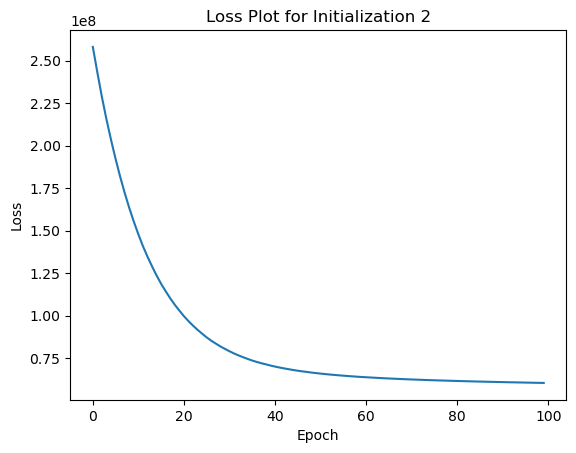

Sample from the guide (posterior)
Extract the latent variables
All initializations complete. Returning results.
------------------------------------------------
Saving results to file
Results saved to results_20240126-144606_20_2_factors.pt
------------------------------------------------


In [50]:
K = 20
all_results = factor_model.main(y_tensor, total_counts_tensor, num_initializations=2, use_global_prior=False, K=K, lr=0.1, loss_plot=True, num_epochs=100)

In [51]:
latent_vars = all_results[0]['latent_vars'] # latent variables for just first seed

In [52]:
# extract latent variables
pi = latent_vars["pi"] # overall contribution of each factor to cell population
conc = latent_vars["conc"] # one scaling value 

assign_post = latent_vars["assign"]

psis = latent_vars["psi"] # psi is the probability of a junction being used in a cluster
a = latent_vars["a"] # a is the alpha parameter of the beta distribution (if no global prior used, then this is one value per junction)
b = latent_vars["b"] # b is the beta parameter of the beta distribution (if no global prior used, then this is one value per junction)

In [53]:
print(a.shape)
print(b.shape)

(15929,)
(15929,)


In [41]:
print("The inferred concentration parameter is: " + str(conc))
print("The inferred pi parameter is: " + str(pi))

The inferred concentration parameter is: 28.148428
The inferred pi parameter is: [0.04811379 0.09145408 0.00891728 0.00879026 0.01886745 0.0088794
 0.03956046 0.0080018  0.03642275 0.00694356 0.05017937 0.08025005
 0.00723724 0.00729326 0.00725399 0.01085009 0.00596306 0.00638726
 0.03457633 0.00708301 0.00715263 0.00634646 0.00714776 0.00711943
 0.02544785 0.00683034 0.01660331 0.00672563 0.00652915 0.00669874
 0.02027981 0.01435705 0.01596103 0.00567458 0.00907032 0.00524257
 0.01198625 0.0132831  0.00504292 0.01120275 0.01261868 0.00484826
 0.00500228 0.00536319 0.00953799 0.00525203 0.00942649 0.01011527
 0.01000166 0.00941168 0.00689199 0.00468801 0.00821116 0.0046792
 0.00442268 0.00433405 0.0076515  0.0041629  0.00420737 0.00437928
 0.00445174 0.00743254 0.00450588 0.0068488  0.00399043 0.00404344
 0.00404962 0.00679628 0.00419407 0.00414087 0.00545337 0.00629188
 0.00360792 0.00585619 0.00384328 0.00579567 0.00357721 0.00350159
 0.00431294 0.00353049 0.00363143 0.00529497 0.003

In [42]:
mu=a/(a+b)
s=a+b

print(mu)
print(s)

[0.35837483 0.3658471  0.52261776 0.47498593 0.37306914 0.53434896
 0.3473542  0.42418778 0.33997923 0.38305506 0.35681936 0.3884217
 0.45522338 0.57613385 0.4843902  0.3648084  0.38496393 0.37941778
 0.3608539  0.46746296 0.48195782 0.40217075 0.52949065 0.5835632
 0.35967636 0.44556263 0.37883794 0.44890743 0.48760733 0.36477998
 0.3130636  0.3761749  0.3060435  0.3770428  0.38807264 0.3920526
 0.39761257 0.27680928 0.39586908 0.38628298 0.32159126 0.41332012
 0.4710847  0.4467111  0.39509615 0.404586   0.3665794  0.3561781
 0.32905507 0.33121383 0.40604016 0.49721918 0.33449703 0.40712282
 0.4217304  0.40186793 0.38024577 0.40518007 0.5280705  0.49053326
 0.51827264 0.31448257 0.39369723 0.31798822 0.42105922 0.46151727
 0.51554227 0.29668832 0.44377932 0.485574   0.39660007 0.33203158
 0.64734846 0.30726042 0.50440496 0.2656965  0.42962605 0.39742053
 0.39317104 0.3944163  0.53304    0.34291542 0.4137957  0.36666766
 0.38541055 0.4658944  0.47439125 0.38871142 0.40199292 0.4362362


### Evaluate latent variables 

In [43]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

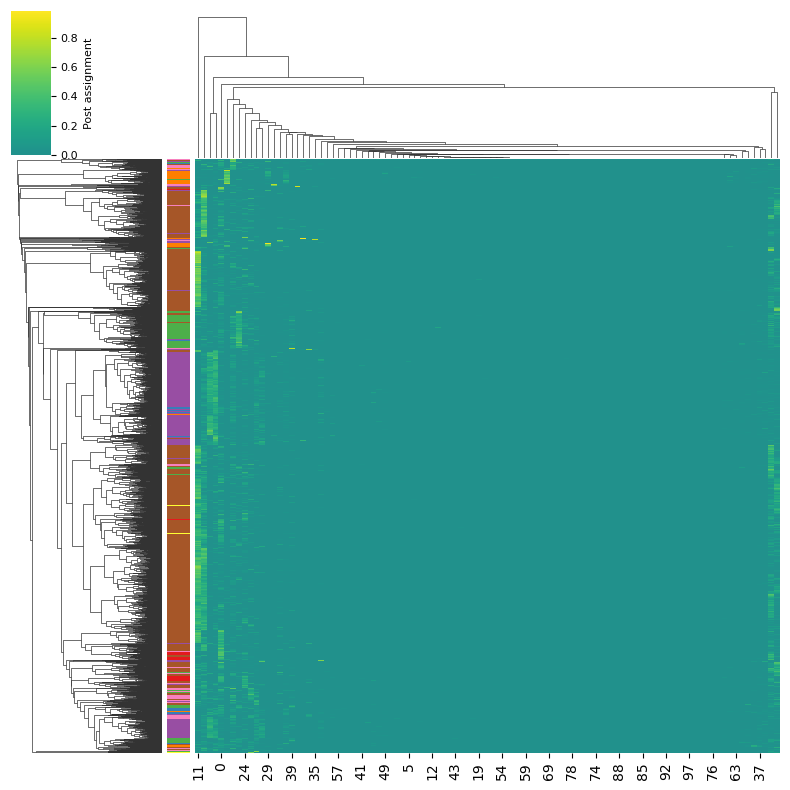

In [44]:
cluster = sns.clustermap(
    data=assign_post,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'Post assignment'} 
    )
cluster.cax.set_ylabel('Post assignment', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

Text(0.5, 0, 'Cell Type')

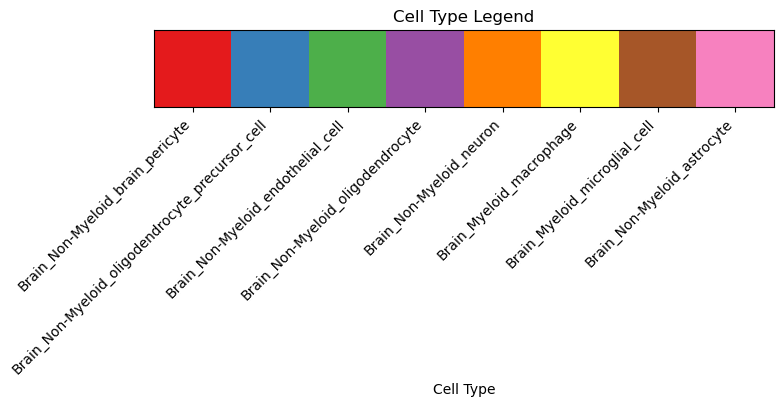

In [45]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")


In [46]:
# let's calculate silhouette score ussing assign_post
ss = silhouette_score(assign_post, cell_types)
# print with K equals K the ss is 
print("The silhouette score for K = " + str(K) + " is: " + str(ss))

The silhouette score for K = 100 is: 0.03539594


In [47]:
# get davies bouldin score
from sklearn.metrics import davies_bouldin_score
dbs = davies_bouldin_score(assign_post, cell_types)
print("The Davies Bouldin score for K = " + str(K) + " is: " + str(dbs))

The Davies Bouldin score for K = 100 is: 2.780976050730202


## Evaluate perfomrance on imputation/masking task

In [38]:
# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/evaluations')
import masking
from masking import *

In [39]:
# import reload 
from importlib import reload
reload(masking)

<module 'masking' from '/gpfs/commons/home/kisaev/Leaflet/src/evaluations/masking.py'>

In [30]:
#1. get masked matrix using intron cluster counts for this mouse brain data 
masks = generate_mask(cluster_counts)

Number of entries (junction-cell pairs) masked:  1054635.0


In [31]:
#2. get junction and intron cluster count matrices with masked values 
masked_junction_counts, masked_intron_clusts = apply_mask(junc_counts, cluster_counts, masks)

In [32]:
#3. get input files for factor model (junction and intron cluster sparse tensor)
y_tensor, total_counts_tensor = prep_model_input(masked_junction_counts, masked_intron_clusts)

/gpfs/commons/home/kisaev/Leaflet/src/evaluations/masking.py:129: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  indices = torch.tensor(np.nonzero(masked_intron_clusts), dtype=torch.long)


In [33]:
# Now can run factor model on masked data
K = [2, 5, 8, 20, 50, 100]
all_Ks_results = {}
for k in K:
    print("Running factor model for K = " + str(k))
    all_Ks_results[k] = factor_model.main(y_tensor, total_counts_tensor, num_initializations=3, use_global_prior=False, K=k, lr=0.1, loss_plot=False, num_epochs=100)
    print("Done running factor model for K = " + str(k))

Running factor model for K = 2
Not using global prior for psi, junctions are independent across factors
Initialization 1 with seed 3491
Define the guide
Fit the model
Epoch 0, Loss: 242882525.00137067
Epoch 10, Loss: 138219773.92714414
Epoch 20, Loss: 93155537.8203702
Epoch 30, Loss: 75928713.79172999
Epoch 40, Loss: 69036292.48261452
Epoch 50, Loss: 66121962.49514592
Epoch 60, Loss: 64620615.841154814
Epoch 70, Loss: 63703306.49123478
Epoch 80, Loss: 62911219.20832336
Epoch 90, Loss: 62133086.01357454
Sample from the guide (posterior)
Extract the latent variables
Initialization 2 with seed 9424
Define the guide
Fit the model
Epoch 0, Loss: 250972281.92602527
Epoch 10, Loss: 142993060.3127532
Epoch 20, Loss: 96078447.84729695
Epoch 30, Loss: 77242849.80148733
Epoch 40, Loss: 69315900.59913975
Epoch 50, Loss: 65738273.12968874
Epoch 60, Loss: 63808456.9431811
Epoch 70, Loss: 62526874.26148152
Epoch 80, Loss: 61563554.5660314
Epoch 90, Loss: 60872479.485168636
Sample from the guide (post

In [52]:
# get pearson correlation and l1 error between true and inferred parameters (PSI)
Ks = [2, 5, 8, 20, 100] # doesn't work with 100

masked_perf = []

for k in Ks:
    print("Calculating performance for K = " + str(k))
    masked_results = all_Ks_results[k]
    for res in masked_results:
        
        # get seed that was used 
        seed = res['seed']
        
        # get latent variables
        psi = res['latent_vars']["psi"] # psi is the probability of a junction being used in a cluster
        assign_post=res['latent_vars']["assign"]

        # get K 
        K = psi.shape[0]
        J = psi.shape[1]

        # get scores 
        l1, r = evaluate_model(junc_counts.toarray(), cluster_counts.toarray(), psi, assign_post, masks)

        # get num epochs trained for 
        nepoch = len(res["losses"])

        # save to list 
        masked_perf.append([seed, l1, r, K, J, nepoch])

Calculating performance for K = 2


/gpfs/commons/home/kisaev/Leaflet/src/evaluations/masking.py:177: RuntimeWarning: invalid value encountered in divide
  true_psi = true_juncs / true_clusts


L1 error:  0.17220495128999022
Pearson correlation:  0.7246880314768054
L1 error:  0.17028237732570278
Pearson correlation:  0.7292222808594623
L1 error:  0.17153085390295297
Pearson correlation:  0.7274132380254488
Calculating performance for K = 5
L1 error:  0.1668551199778808
Pearson correlation:  0.7356543686208178
L1 error:  0.16677479274289306
Pearson correlation:  0.7363028299446908
L1 error:  0.1684668632973576
Pearson correlation:  0.7328791799029557
Calculating performance for K = 8
L1 error:  0.16541021008512768
Pearson correlation:  0.7379998828802803
L1 error:  0.16502034550816166
Pearson correlation:  0.7386499056213515
L1 error:  0.16691306352523175
Pearson correlation:  0.7355576621069563
Calculating performance for K = 20
L1 error:  0.16420219897642646
Pearson correlation:  0.7396164789115475
L1 error:  0.16609012453084596
Pearson correlation:  0.7361646382440904
L1 error:  0.16523441575347625
Pearson correlation:  0.7381239993183853
Calculating performance for K = 5
L

In [53]:
# make masked_perf a dataframe 
masked_perf_df = pd.DataFrame(masked_perf, columns=["seed", "l1", "r", "K", "J", "num_epochs"])

<Axes: xlabel='K', ylabel='l1'>

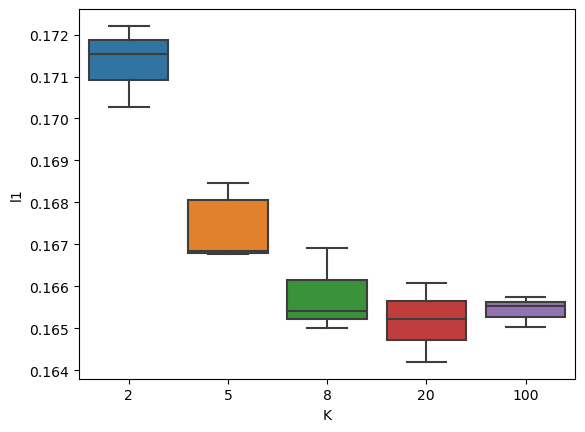

In [54]:
# make boxplot of l1 error for each K
sns.boxplot(data=masked_perf_df, x="K", y="l1")

<Axes: xlabel='K', ylabel='r'>

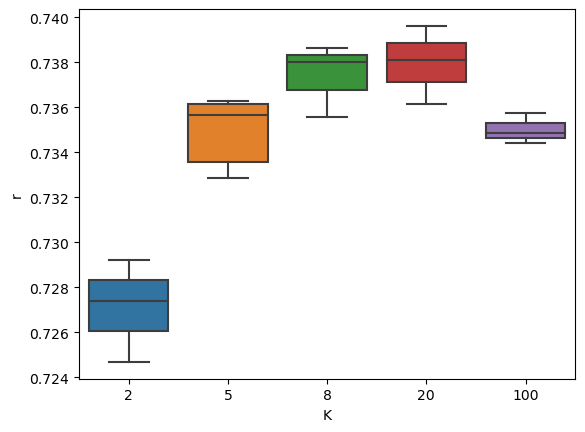

In [55]:
# make boxplot of pearson correlation for each K
sns.boxplot(data=masked_perf_df, x="K", y="r")

## Try now with global priors on psi across factors 

In [45]:
# Now can run factor model on masked data
K = [2, 5, 8, 20, 5, 100] # doesn't work with 100
all_Ks_results_prior = {}
for k in K:
    
    print("-----------------------------------------")
    print("Running factor model for K = " + str(k))
    all_Ks_results_prior[k] = factor_model.main(y_tensor, total_counts_tensor, num_initializations=3, file_prefix = "with_prior", use_global_prior=True, K=k, lr=0.1, loss_plot=False, num_epochs=100)
    print("Done running factor model for K = " + str(k))
    print("-----------------------------------------")

15929

In [48]:
# get pearson correlation and l1 error between true and inferred parameters (PSI)

masked_perf_prior = []
Ks = [2, 5, 8, 20, 5, 100] # doesn't work with 100

for k in Ks:
    print("Calculating performance for K = " + str(k))
    print("-----------------------------------------")
    masked_results = all_Ks_results_prior[k]
    for res in masked_results:
        
        # get seed that was used 
        seed = res['seed']
        
        # get latent variables
        psi = res['latent_vars']["psi"] # psi is the probability of a junction being used in a cluster
        psi = psi.T
        assign_post=res['latent_vars']["assign"]

        # get K 
        K = psi.shape[0]
        J = psi.shape[1]

        # get scores 
        l1, r = evaluate_model(junc_counts.toarray(), cluster_counts.toarray(), psi, assign_post, masks)

        # get num epochs trained for 
        nepoch = len(res["losses"])

        # save to list 
        masked_perf_prior.append([seed, l1, r, K, J, nepoch])

Calculating performance for K = 2
-----------------------------------------


L1 error:  0.1743982185972882
Pearson correlation:  0.7160191038500354
L1 error:  0.1759447346884385
Pearson correlation:  0.7157667647433074
L1 error:  0.1733730969299363
Pearson correlation:  0.71992557000516
Calculating performance for K = 5
-----------------------------------------
L1 error:  0.17417466749036806
Pearson correlation:  0.7174157334440147
L1 error:  0.17030819608650705
Pearson correlation:  0.7276883523762069
L1 error:  0.16992302264152678
Pearson correlation:  0.7285357266076754
Calculating performance for K = 8
-----------------------------------------
L1 error:  0.17043971421207849
Pearson correlation:  0.7279417763302509
L1 error:  0.1705667040363547
Pearson correlation:  0.7257478253299489
L1 error:  0.1682676540988344
Pearson correlation:  0.7319685651555098
Calculating performance for K = 20
-----------------------------------------
L1 error:  0.1660683753380584
Pearson correlation:  0.7358403179547656
L1 error:  0.16711671344569168
Pearson correlation:  0.7334

In [49]:
# make masked_perf a dataframe 
masked_perf_df = pd.DataFrame(masked_perf_prior, columns=["seed", "l1", "r", "K", "J", "num_epochs"])

<Axes: xlabel='K', ylabel='l1'>

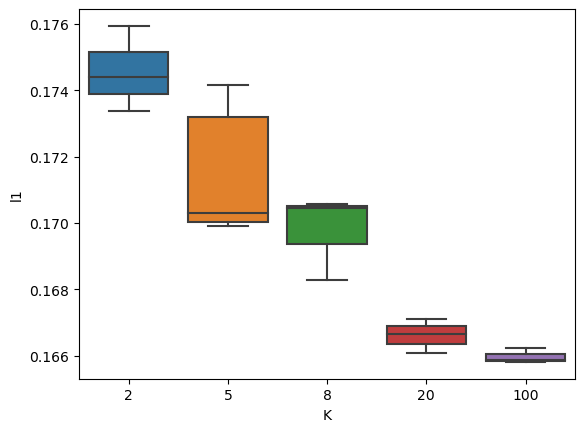

In [50]:
# make boxplot of l1 error for each K
sns.boxplot(data=masked_perf_df, x="K", y="l1")

<Axes: xlabel='K', ylabel='r'>

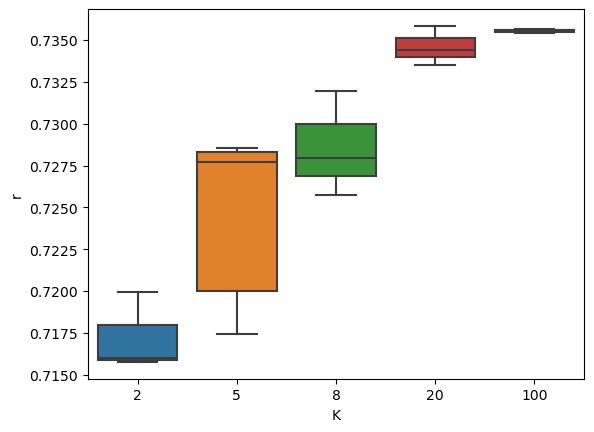

In [51]:
# make boxplot of pearson correlation for each K
sns.boxplot(data=masked_perf_df, x="K", y="r")

In [63]:
all_Ks_results_prior[100][0]["latent_vars"]["psi"]

array([[0.42748508, 0.4151918 , 0.07068469, ..., 0.8658438 , 0.42084745,
        0.8446536 ],
       [0.4957663 , 0.55332977, 0.8723415 , ..., 0.11710903, 0.27536055,
        0.7158178 ],
       [0.00716413, 0.8969965 , 0.01299893, ..., 0.8059332 , 0.39963657,
        0.11355391],
       ...,
       [0.00829803, 0.00680489, 0.00837578, ..., 0.01920343, 0.22763385,
        0.29032746],
       [0.7636454 , 0.02435242, 0.63768923, ..., 0.17696029, 0.6630769 ,
        0.46291304],
       [0.95042425, 0.8363094 , 0.0034342 , ..., 0.09652822, 0.41939688,
        0.73241913]], dtype=float32)

In [66]:
a = all_Ks_results_prior[100][0]["latent_vars"]["a"]
b = all_Ks_results_prior[100][0]["latent_vars"]["b"]

In [67]:
mu = a/(a+b)
s = a+b

print(mu)
print(s)

[0.37585825 0.34628657 0.36789563 0.4175826  0.30001798 0.45385394
 0.38046628 0.37288702 0.21374443 0.5112427  0.2813838  0.4104697
 0.4070121  0.4507731  0.40279388 0.5253558  0.3541036  0.40906549
 0.34173328 0.4617698  0.39072835 0.38162658 0.43978652 0.4073727
 0.34603325 0.5079835  0.5944527  0.41171268 0.35527673 0.6258429
 0.5304213  0.47049943 0.3942092  0.5186325  0.40664086 0.42332044
 0.34622827 0.465174   0.4792406  0.39699322 0.37346938 0.40148142
 0.42814317 0.45270512 0.4552619  0.40794766 0.46372813 0.4114353
 0.4881602  0.3506879  0.45918497 0.6207883  0.4191095  0.3898027
 0.45395693 0.35678825 0.39075547 0.37657693 0.43353108 0.4367113
 0.51749533 0.31358418 0.42144346 0.37305352 0.41024354 0.39577773
 0.65485287 0.39059716 0.5242966  0.42484602 0.6136963  0.27653578
 0.3588783  0.32937768 0.37637228 0.45724362 0.38279998 0.34472427
 0.38805228 0.4069115  0.35791954 0.28508893 0.5342575  0.37219703
 0.44748935 0.3762756  0.39526063 0.37719294 0.43674475 0.35999668
 

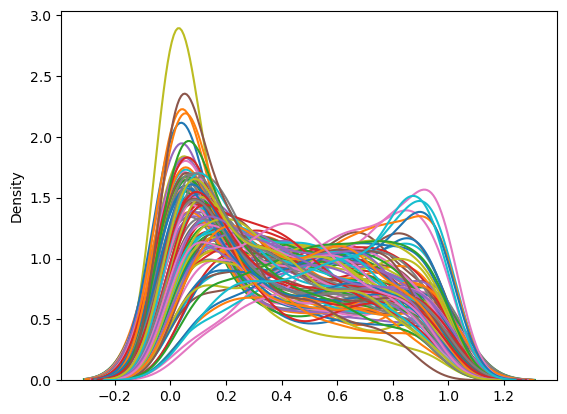

In [77]:
# visualize all the beta distributions made by mu, s 
# plot beta distributions for each factor using mu and s
for i in range(len(a)):
    sns.kdeplot(np.random.beta(a[i], b[i], 500), label="Factor " + str(i))

1.3848883
0.8986277


<Axes: ylabel='Density'>

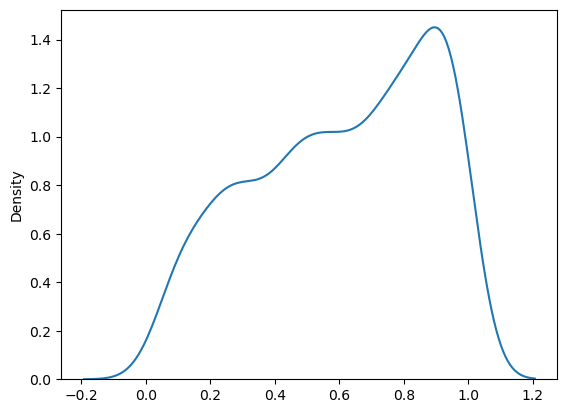

In [80]:
i=99

print(a[i])
print(b[i])

sns.kdeplot(np.random.beta(a[i], b[i], 1000), label="Factor " + str(i))

In [49]:
len(a)

100